# HW6_programAnswer

**Due to 11:59 pm, 2th, December 2020**

**This is an individual assignment.**

公式请参考《PRML》Chapter7 Sparse Kernel Machines

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

In [14]:
class Kernel(object):
    """
    Base class for kernel function
    """

    def _pairwise(self, x, y):
        """
        all pairs of x and y

        Parameters
        ----------
        x : (sample_size, n_features)
            input
        y : (sample_size, n_features)
            another input

        Returns
        -------
        output : tuple
            two array with shape (sample_size, sample_size, n_features)
        """
        return (
            np.tile(x, (len(y), 1, 1)).transpose(1, 0, 2),
            np.tile(y, (len(x), 1, 1))
        )

In [15]:
class RBF(Kernel):

    def __init__(self, params):
        """
        construct Radial basis kernel function

        Parameters
        ----------
        params : (ndim + 1,) ndarray
            parameters of radial basis function

        Attributes
        ----------
        ndim : int
            dimension of expected input data
        """
        assert params.ndim == 1
        self.params = params
        self.ndim = len(params) - 1

    def __call__(self, x, y, pairwise=True):
        """
        calculate radial basis function
        k(x, y) = c0 * exp(-0.5 * c1 * (x1 - y1) ** 2 ...)

        Parameters
        ----------
        x : ndarray [..., ndim]
            input of this kernel function
        y : ndarray [..., ndim]
            another input

        Returns
        -------
        output : ndarray
            output of this radial basis function
        """
        assert x.shape[-1] == self.ndim
        assert y.shape[-1] == self.ndim
        if pairwise:
            x, y = self._pairwise(x, y)
        d = self.params[1:] * (x - y) ** 2
        # Complete your codes here
        return self.params[0] * np.exp(-0.5 * np.sum(d, axis=-1))
        
        
        
        
        


    def derivatives(self, x, y, pairwise=True):
        if pairwise:
            x, y = self._pairwise(x, y)
        d = self.params[1:] * (x - y) ** 2
        delta = np.exp(-0.5 * np.sum(d, axis=-1))
        # Complete your codes here
        deltas = -0.5 * (x - y) ** 2 * (delta * self.params[0])[:, :, None]
        return np.concatenate((np.expand_dims(delta, 0), deltas.T))
        
        
        
        
        
        


    def update_parameters(self, updates):
        self.params += updates

In [16]:
class PolynomialKernel(Kernel):
    """
    Polynomial kernel
    k(x,y) = (x @ y + c)^M
    """

    def __init__(self, degree=2, const=0.):
        """
        construct Polynomial kernel

        Parameters
        ----------
        const : float
            a constant to be added
        degree : int
            degree of polynomial order
        """
        self.const = const
        self.degree = degree

    def __call__(self, x, y, pairwise=True):
        """
        calculate pairwise polynomial kernel

        Parameters
        ----------
        x : (..., ndim) ndarray
            input
        y : (..., ndim) ndarray
            another input with the same shape

        Returns
        -------
        output : ndarray
            polynomial kernel
        """
        if pairwise:
        # Complete your codes here
             x, y = self._pairwise(x, y)
        return (np.sum(x * y, axis=-1) + self.const) ** self.degree







In [17]:
class SupportVectorClassifier(object):

    def __init__(self, kernel, C=np.Inf):
        """
        construct support vector classifier

        Parameters
        ----------
        kernel : Kernel
            kernel function to compute inner products
        C : float
            penalty of misclassification
        """
        self.kernel = kernel
        self.C = C

    def fit(self, X:np.ndarray, t:np.ndarray, tol:float=1e-8):
        """
        estimate support vectors and their parameters

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
            binary -1 or 1
        tol : float, optional
            numerical tolerance (the default is 1e-8)
        """

        N = len(t)
        coef = np.zeros(N)
        grad = np.ones(N)
        Gram = self.kernel(X, X)

        while True:
            tg = t * grad
            mask_up = (t == 1) & (coef < self.C - tol)
            mask_up |= (t == -1) & (coef > tol)
            mask_down = (t == -1) & (coef < self.C - tol)
            mask_down |= (t == 1) & (coef > tol)
            i = np.where(mask_up)[0][np.argmax(tg[mask_up])]
            j = np.where(mask_down)[0][np.argmin(tg[mask_down])]
            if tg[i] < tg[j] + tol:
                self.b = 0.5 * (tg[i] + tg[j])
                break
            else:
                A = self.C - coef[i] if t[i] == 1 else coef[i]
                B = coef[j] if t[j] == 1 else self.C - coef[j]
                direction = (tg[i] - tg[j]) / (Gram[i, i] - 2 * Gram[i, j] + Gram[j, j])
                direction = min(A, B, direction)
                coef[i] += direction * t[i]
                coef[j] -= direction * t[j]
                grad -= direction * t * (Gram[i] - Gram[j])
        support_mask = coef > tol
        self.a = coef[support_mask]
        self.X = X[support_mask]
        self.t = t[support_mask]

    def lagrangian_function(self):
        return (
            np.sum(self.a)
            - self.a
            @ (self.t * self.t[:, None] * self.kernel(self.X, self.X))
            @ self.a)

    def predict(self, x):
        """
        predict labels of the input

        Parameters
        ----------
        x : (sample_size, n_features) ndarray
            input

        Returns
        -------
        label : (sample_size,) ndarray
            predicted labels
        """
        y = self.distance(x)
        label = np.sign(y)
        return label

    def distance(self, x):
        """
        calculate distance from the decision boundary

        Parameters
        ----------
        x : (sample_size, n_features) ndarray
            input

        Returns
        -------
        distance : (sample_size,) ndarray
            distance from the boundary
        """
        # Complete your codes here
        distance = np.sum(
            self.a * self.t
            * self.kernel(x, self.X),
            axis=-1) + self.b
        return distance
        
        
        
        
        
        


In [18]:
class RelevanceVectorRegressor(object):

    def __init__(self, kernel, alpha=1., beta=1.):
        """
        construct relevance vector regressor

        Parameters
        ----------
        kernel : Kernel
            kernel function to compute components of feature vectors
        alpha : float
            initial precision of prior weight distribution
        beta : float
            precision of observation
        """
        self.kernel = kernel
        self.alpha = alpha
        self.beta = beta

    def fit(self, X, t, iter_max=1000):
        """
        maximize evidence with respect to hyperparameter

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input
        t : (sample_size,) ndarray
            corresponding target
        iter_max : int
            maximum number of iterations

        Attributes
        -------
        X : (N, n_features) ndarray
            relevance vector
        t : (N,) ndarray
            corresponding target
        alpha : (N,) ndarray
            hyperparameter for each weight or training sample
        cov : (N, N) ndarray
            covariance matrix of weight
        mean : (N,) ndarray
            mean of each weight
        """
        if X.ndim == 1:
            X = X[:, None]
        assert X.ndim == 2
        assert t.ndim == 1
        N = len(t)
        Phi = self.kernel(X, X)
        self.alpha = np.zeros(N) + self.alpha
        for _ in range(iter_max):
            params = np.hstack([self.alpha, self.beta])
            precision = np.diag(self.alpha) + self.beta * Phi.T @ Phi
            covariance = np.linalg.inv(precision)
            mean = self.beta * covariance @ Phi.T @ t
            gamma = 1 - self.alpha * np.diag(covariance)
            self.alpha = gamma / np.square(mean)
            np.clip(self.alpha, 0, 1e10, out=self.alpha)
            self.beta = (N - np.sum(gamma)) / np.sum((t - Phi.dot(mean)) ** 2)
            if np.allclose(params, np.hstack([self.alpha, self.beta])):
                break
        mask = self.alpha < 1e9
        self.X = X[mask]
        self.t = t[mask]
        self.alpha = self.alpha[mask]
        Phi = self.kernel(self.X, self.X)
        precision = np.diag(self.alpha) + self.beta * Phi.T @ Phi
        self.covariance = np.linalg.inv(precision)
        self.mean = self.beta * self.covariance @ Phi.T @ self.t

    def predict(self, X, with_error=True):
        """
        predict output with this model

        Parameters
        ----------
        X : (sample_size, n_features)
            input
        with_error : bool
            if True, predict with standard deviation of the outputs

        Returns
        -------
        mean : (sample_size,) ndarray
            mean of predictive distribution
        std : (sample_size,) ndarray
            standard deviation of predictive distribution
        """
        if X.ndim == 1:
            X = X[:, None]
        assert X.ndim == 2
        phi = self.kernel(X, self.X)
        mean = phi @ self.mean
        if with_error:
            var = 1 / self.beta + np.sum(phi @ self.covariance * phi, axis=1)
            return mean, np.sqrt(var)
        return mean

In [19]:
class RelevanceVectorClassifier(object):

    def __init__(self, kernel, alpha=1.):
        """
        construct relevance vector classifier

        Parameters
        ----------
        kernel : Kernel
            kernel function to compute components of feature vectors
        alpha : float
            initial precision of prior weight distribution
        """
        self.kernel = kernel
        self.alpha = alpha

    def _sigmoid(self, a):
        return np.tanh(a * 0.5) * 0.5 + 0.5

    def _map_estimate(self, X, t, w, n_iter=10):
        for _ in range(n_iter):
            y = self._sigmoid(X @ w)
            g = X.T @ (y - t) + self.alpha * w
            H = (X.T * y * (1 - y)) @ X + np.diag(self.alpha)
            w -= np.linalg.solve(H, g)
        return w, np.linalg.inv(H)

    def fit(self, X, t, iter_max=100):
        """
        maximize evidence with respect ot hyperparameter

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input
        t : (sample_size,) ndarray
            corresponding target
        iter_max : int
            maximum number of iterations

        Attributes
        ----------
        X : (N, n_features) ndarray
            relevance vector
        t : (N,) ndarray
            corresponding target
        alpha : (N,) ndarray
            hyperparameter for each weight or training sample
        cov : (N, N) ndarray
            covariance matrix of weight
        mean : (N,) ndarray
            mean of each weight
        """
        # Complete your codes here
        if X.ndim == 1:
            X = X[:, None]
        assert X.ndim == 2
        assert t.ndim == 1
        Phi = self.kernel(X, X)
        N = len(t)
        self.alpha = np.zeros(N) + self.alpha
        mean = np.zeros(N)
        for _ in range(iter_max):
            param = np.copy(self.alpha)
            mean, cov = self._map_estimate(Phi, t, mean, 10)
            gamma = 1 - self.alpha * np.diag(cov)
            self.alpha = gamma / np.square(mean)
            np.clip(self.alpha, 0, 1e10, out=self.alpha)
            if np.allclose(param, self.alpha):
                break
        mask = self.alpha < 1e8
        self.X = X[mask]
        self.t = t[mask]
        self.alpha = self.alpha[mask]
        Phi = self.kernel(self.X, self.X)
        mean = mean[mask]
        self.mean, self.covariance = self._map_estimate(Phi, self.t, mean, 100)
        
        
    def predict(self, X):
        """
        predict class label

        Parameters
        ----------
        X : (sample_size, n_features)
            input

        Returns
        -------
        label : (sample_size,) ndarray
            predicted label
        """
        if X.ndim == 1:
            X = X[:, None]
        assert X.ndim == 2
        phi = self.kernel(X, self.X)
        label = (phi @ self.mean > 0).astype(np.int)
        return label

    def predict_proba(self, X):
        """
        probability of input belonging class one

        Parameters
        ----------
        X : (sample_size, n_features) ndarray
            input

        Returns
        -------
        proba : (sample_size,) ndarray
            probability of predictive distribution p(C1|x)
        """
        if X.ndim == 1:
            X = X[:, None]
        assert X.ndim == 2
        phi = self.kernel(X, self.X)
        mu_a = phi @ self.mean
        var_a = np.sum(phi @ self.covariance * phi, axis=1)
        return self._sigmoid(mu_a / np.sqrt(1 + np.pi * var_a / 8))

## 1. Maximum Margin Classifiers
Please finish the class **SupportVectorClassifier, PolynomialKernel** above and show the maximum margin classifiers figure with the given codes.

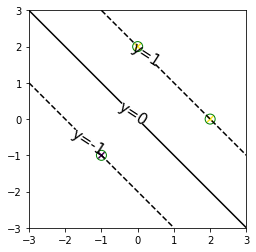

In [20]:
x_train = np.array([
        [0., 2.],
        [2., 0.],
        [-1., -1.]])
y_train = np.array([1., 1., -1.])

model = SupportVectorClassifier(PolynomialKernel(degree=1))
model.fit(x_train, y_train)
x0, x1 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(x_train[:, 0], x_train[:, 1], s=40, c=y_train, marker="x")
plt.scatter(model.X[:, 0], model.X[:, 1], s=100, facecolor="none", edgecolor="g")
cp = plt.contour(x0, x1, model.distance(x).reshape(100, 100), np.array([-1, 0, 1]), colors="k", linestyles=("dashed", "solid", "dashed"))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect("equal", adjustable="box")

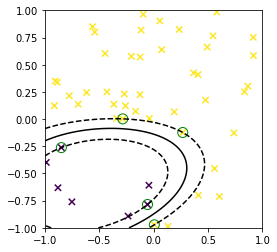

In [21]:
def create_toy_data():
    x = np.random.uniform(-1, 1, 100).reshape(-1, 2)
    y = x < 0
    y = (y[:, 0] * y[:, 1]).astype(np.float)
    return x, 1 - 2 * y

x_train, y_train = create_toy_data()

model = SupportVectorClassifier(RBF(np.ones(3)))
model.fit(x_train, y_train)

x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(x_train[:, 0], x_train[:, 1], s=40, c=y_train, marker="x")
plt.scatter(model.X[:, 0], model.X[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contour(
    x0, x1, model.distance(x).reshape(100, 100),
    np.arange(-1, 2), colors="k", linestyles=("dashed", "solid", "dashed"))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")

### 1.1. Overlapping class distributions

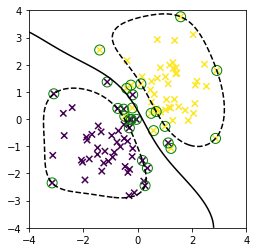

In [22]:
def create_toy_data():
    x0 = np.random.normal(size=100).reshape(-1, 2) - 1.
    x1 = np.random.normal(size=100).reshape(-1, 2) + 1.
    x = np.concatenate([x0, x1])
    y = np.concatenate([-np.ones(50), np.ones(50)]).astype(np.int)
    return x, y

x_train, y_train = create_toy_data()

model = SupportVectorClassifier(RBF(np.array([1., 0.5, 0.5])), C=1.)
model.fit(x_train, y_train)

x0, x1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(x_train[:, 0], x_train[:, 1], s=40, c=y_train, marker="x")
plt.scatter(model.X[:, 0], model.X[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contour(x0, x1, model.distance(x).reshape(100, 100), np.arange(-1, 2), colors="k", linestyles=("dashed", "solid", "dashed"))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal", adjustable="box")

## 2. Relevance Vector Machines

### 2.1. RVM for regression

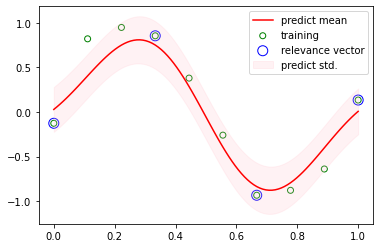

In [23]:
def create_toy_data(n=10):
    x = np.linspace(0, 1, n)
    t = np.sin(2 * np.pi * x) + np.random.normal(scale=0.1, size=n)
    return x, t

x_train, y_train = create_toy_data(n=10)
x = np.linspace(0, 1, 100)

model = RelevanceVectorRegressor(RBF(np.array([1., 20.])))
model.fit(x_train, y_train)

y, y_std = model.predict(x)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="g", label="training")
plt.scatter(model.X.ravel(), model.t, s=100, facecolor="none", edgecolor="b", label="relevance vector")
plt.plot(x, y, color="r", label="predict mean")
plt.fill_between(x, y - y_std, y + y_std, color="pink", alpha=0.2, label="predict std.")
plt.legend(loc="best")
plt.show()

### 2.2. RVM for classification

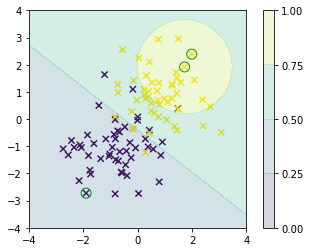

In [24]:
def create_toy_data():
    x0 = np.random.normal(size=100).reshape(-1, 2) - 1.
    x1 = np.random.normal(size=100).reshape(-1, 2) + 1.
    x = np.concatenate([x0, x1])
    y = np.concatenate([np.zeros(50), np.ones(50)]).astype(np.int)
    return x, y

x_train, y_train = create_toy_data()

model = RelevanceVectorClassifier(RBF(np.array([1., 0.5, 0.5])))
model.fit(x_train, y_train)

x0, x1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(x_train[:, 0], x_train[:, 1], s=40, c=y_train, marker="x")
plt.scatter(model.X[:, 0], model.X[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contourf(x0, x1, model.predict_proba(x).reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal", adjustable="box")

In [25]:
print('end')


end
